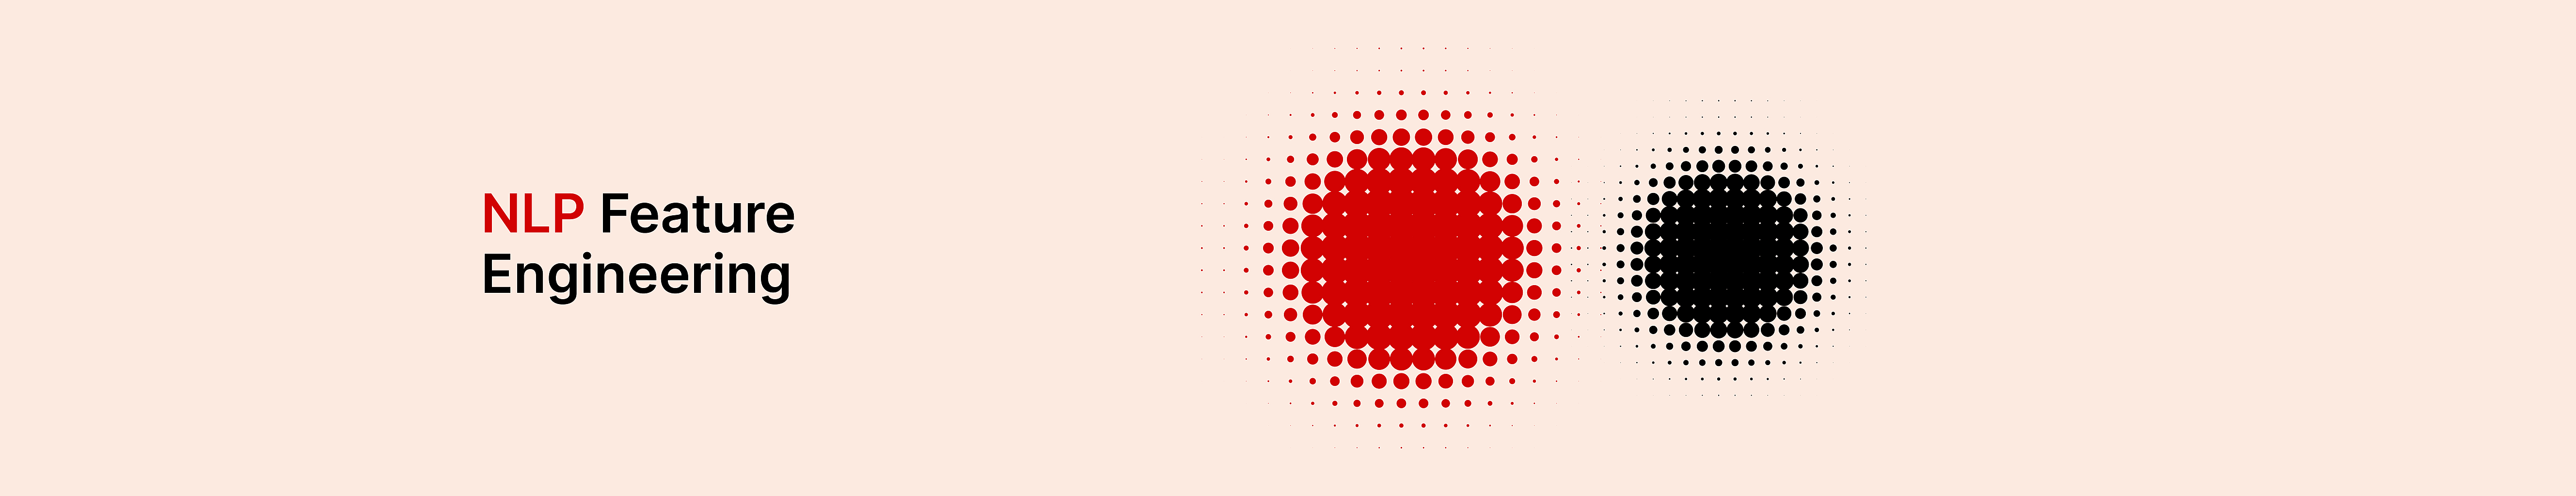

<h2><center>Starter Code for Feature Engineering</center></h2>

<!-- <h6><center>Author : Shubhamai</center></h6> -->



<!-- --- -->



### What we are going to Learn

  - How to convert your text into numbers ?
  - How Bag of words, TF-IDF, Word2Vec works ?
  - Testing and Submitting the Results to the Challenge. 

## About this Challanges

Now, this challange is very different form what we usually do in AIcrowd Blitz.In this challanges, the task is to generate features from a text data. So, what i mean by features ? it is simply to extract meaningful information about a text, let's take an example. 

```
Crop diseases are a major threat to food securit. The combination of increasing global smartphone
penetration and recent advances in computer vision made possible by deep
learning has paved the way for smartphone-assisted disease diagnosis. Using a
public dataset of 54,306 images of diseased and healthy plant leaves collected
under controlled conditions, we train a deep convolutional neural network to
identify 14 crop species and 26 diseases (or absence thereof). The trained
model achieves an accuracy of 99.35% on a held-out test set, demonstrating the
feasibility of this approach.Overall, the approach of training deep learning models on
increasingly large and publicly available image datasets presents a clear path
towards smartphone-assisted crop disease diagnosis on a massive global scale.
```

He we can see that the para seems contains words like images, neural network etc, with these features, we quickly figured out that this seems to be a rsearch paper Deep Learning & Computer Vision. Extracting features like these helps up to generate text embeddings will contains more useful information about the text. 


# Setup AIcrowd Utilities 🛠

We use this to bundle the files for submission and create a submission on AIcrowd. Do not edit this block.

In [1]:
!pip install -q -U aicrowd-cli

     |████████████████████████████████| 51kB 6.2MB/s 
     |████████████████████████████████| 61kB 7.4MB/s 
     |████████████████████████████████| 215kB 27.4MB/s 
     |████████████████████████████████| 81kB 9.7MB/s 
     |████████████████████████████████| 174kB 43.6MB/s 
     |████████████████████████████████| 61kB 7.0MB/s 
     |████████████████████████████████| 51kB 5.6MB/s 
     |████████████████████████████████| 71kB 8.8MB/s 
ERROR: google-colab 1.0.0 has requirement requests~=2.23.0, but you'll have requests 2.25.1 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.


## How to use this notebook? 📝

<p style="text-align: center"><img src="https://gitlab.aicrowd.com/aicrowd/assets/-/raw/master/notebook/aicrowd_notebook_submission_flow.png?inline=false" alt="notebook overview" style="width: 650px;"/></p>

- **Update the config parameters**. You can define the common variables here

Variable | Description
--- | ---
`AICROWD_DATASET_PATH` | Path to the file containing test data (The data will be available at `/data/` on aridhia workspace). This should be an absolute path.
`AICROWD_OUTPUTS_PATH` | Path to write the output to.
`AICROWD_ASSETS_DIR` | In case your notebook needs additional files (like model weights, etc.,), you can add them to a directory and specify the path to the directory here (please specify relative path). The contents of this directory will be sent to AIcrowd for evaluation.
`AICROWD_API_KEY` | In order to submit your code to AIcrowd, you need to provide your account's API key. This key is available at https://www.aicrowd.com/participants/me

- **Installing packages**. Please use the [Install packages 🗃](#Install-packages-🗃) section to install the packages
- **Training your models**. All the code within the [Training phase ⚙️](#Training-phase-⚙️) section will be skipped during evaluation. **Please make sure to save your model weights in the assets directory and load them in the predictions phase section** 

## AIcrowd Runtime Configuration 🧷

Define configuration parameters. Please include any files needed for the notebook to run under `ASSETS_DIR`. We will copy the contents of this directory to your final submission file 🙂

The dataset is available under `/data` on the workspace.

In [2]:
import os

# Please use the absolute for the location of the dataset.
# Or you can use relative path with `os.getcwd() + "test_data/test.csv"`
AICROWD_DATASET_PATH = os.getenv("DATASET_PATH", os.getcwd()+"/data/data.csv")
AICROWD_OUTPUTS_PATH = os.getenv("OUTPUTS_DIR", "")
AICROWD_ASSETS_DIR = os.getenv("ASSETS_DIR", "assets")

# Install packages 🗃

We are going to use many different libraries to demonstrate many idfferent techniques to convert text into numbers ( or more specifically vectors )

In [3]:
!pip install --upgrade spacy rich gensim tensorflow scikit-learn
!python -m spacy download en_core_web_sm # Downloaing the model for engligh language will contains many pretrained preprocessing pipelines 

     |████████████████████████████████| 12.8MB 29.4MB/s 
Requirement already up-to-date: rich in /usr/local/lib/python3.7/dist-packages (10.3.0)
     |████████████████████████████████| 23.9MB 106kB/s 
Requirement already up-to-date: tensorflow in /usr/local/lib/python3.7/dist-packages (2.5.0)
     |████████████████████████████████| 22.3MB 55.7MB/s 
     |████████████████████████████████| 460kB 39.6MB/s 
     |████████████████████████████████| 51kB 6.8MB/s 
     |████████████████████████████████| 624kB 39.0MB/s 
     |████████████████████████████████| 9.1MB 35.2MB/s 
ERROR: pathy 0.5.2 has requirement smart-open<4.0.0,>=2.2.0, but you'll have smart-open 5.0.0 which is incompatible.
  Found existing installation: catalogue 1.0.0
    Uninstalling catalogue-1.0.0:
      Successfully uninstalled catalogue-1.0.0
  Found existing installation: srsly 1.0.5
    Uninstalling srsly-1.0.5:
      Successfully uninstalled srsly-1.0.5
  Found existing installation: thinc 7.4.0
    Uninstalling thinc-

# Define preprocessing code 💻

The code that is common between the training and the prediction sections should be defined here. During evaluation, we completely skip the training section. Please make sure to add any common logic between the training and prediction sections here.

In [4]:
# Importing Libraries
import pandas as pd
import numpy as np
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)
import random
from tqdm.notebook import tqdm

# Tensorflow 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score


# Word2vec Implementation
import spacy
nlp = spacy.load('en_core_web_sm', exclude=['tagger', 'ner', 'attribute_ruler', 'lemmatizer'])

from gensim.models import Word2Vec
from gensim.models.phrases import Phrases, Phraser

# To make things more beautiful! 
from rich.console import Console
from rich.table import Table
from rich.segment import Segment
from rich import pretty
pretty.install()

# Seeding everything for getting same results 
random.seed(42)
np.random.seed(42)

# function to display YouTube videos
from IPython.display import YouTubeVideo

/usr/local/lib/python3.7/dist-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [5]:
# Latest version of gensim
import gensim
gensim.__version__

'4.0.1'

In [6]:
# Defining the function for preprocessing test dataset which will run after submitting the notebook

def tokenize_sentence(sentences, num_words=1000, maxlen=512, show=False): 

  # Creating the tokenizer, the num_words represents the vocabulary and assigning OOV token ( out of vocaculary ) for unknown tokenn
  # Which can arise if we input a sentence containing a words that tokenizer don't have in his vocabulary

  tokenizer = Tokenizer(num_words=num_words, oov_token="<OOV>")


  tokenizer.fit_on_texts(sentences)
  
  # Getting the unique ID for each token
  word_index = tokenizer.word_index

  # Convert the senteces into vector
  sequences = tokenizer.texts_to_sequences(sentences)

  # Padding the vectors so that all vectors have the same length
  padded_sequences = pad_sequences(sequences, padding='post', truncating='pre', maxlen=maxlen)


  word_index = np.asarray(word_index)
  sequences = np.asarray(sequences)
  padded_sequences = np.asarray(padded_sequences)

  if show==True:
    console = Console()

    console.log("Word Index. A unique ID is assigned to each token.")
    console.log(word_index)
    console.log("---"*10)

    console.log("Sequences. senteces converted into vector.")
    console.log(np.array(sequences[0]))
    console.log("---"*10)

    console.log("Padded Sequences. Adding,( 0 in this case ) or removing elements to make all vectors in the samples same.")
    console.log(np.array(padded_sequences[0]))
    console.log("---"*10)



  return tokenizer, word_index, sequences, padded_sequences

# Training phase ⚙️

You can define your training code here. This sections will be skipped during evaluation.

## Downloading Dataset

Must be prety familar thing by now :) In case, here we are downloading the challange dataset using AIcrowd CLI 

In [10]:
API_KEY = 'ac5fad5d8a1aa54a5e5b531a131e2340' # Please get your your API Key from [https://www.aicrowd.com/participants/me]
!aicrowd login --api-key $API_KEY

API Key valid
Saved API Key successfully!


In [11]:
# Downloading the Dataset
!mkdir data
!aicrowd dataset download --challenge nlp-feature-engineering -j 3 -o data

# Donwloading emotion classification dataset for testing purposes
!mkdir emotion-detection-data
!aicrowd dataset download --challenge emotion-detection -j 3 -o emotion-detection-data

mkdir: cannot create directory ‘data’: File exists
data.csv: 100% 110k/110k [00:00<00:00, 775kB/s]
mkdir: cannot create directory ‘emotion-detection-data’: File exists
val.csv:   0% 0.00/262k [00:00<?, ?B/s]

test.csv:   0% 0.00/642k [00:00<?, ?B/s]
val.csv: 100% 262k/262k [00:00<00:00, 1.04MB/s]


test.csv: 100% 642k/642k [00:00<00:00, 1.98MB/s]

train.csv: 100% 2.30M/2.30M [00:00<00:00, 5.82MB/s]


### Reading Dataset

Reading the necessary files to train, validation & submit our results! 

We are also using [Emotion Detection Challange](https://www.aicrowd.com/challenges/ai-blitz-9/problems/emotion-detection) dataset for testing purposes.

In [12]:
dataset = pd.read_csv("data/data.csv")
train_data = pd.read_csv("emotion-detection-data/train.csv")

dataset

id 
 text 
 feature 
 
 
 
 
 0 
 0 
 Zero-divisors (ZDs) derived by Cayley-Dickson ... 
 [0.3745401188473625, 0.9507143064099162, 0.731... 
 
 
 1 
 1 
 This paper is an exposition of the so-called i... 
 [0.9327284833540133, 0.8660638895004084, 0.045... 
 
 
 2 
 2 
 Zero-divisors (ZDs) derived by Cayley-Dickson ... 
 [0.9442664891134339, 0.47421421665746377, 0.86... 
 
 
 3 
 3 
 We calculate the equation of state of dense hy... 
 [0.18114934953468032, 0.6811178539649828, 0.18... 
 
 
 4 
 4 
 The Donald-Flanigan conjecture asserts that fo... 
 [0.5435382173426461, 0.08172534574677826, 0.45... 
 
 
 5 
 5 
 Let $E$ be a primarily quasilocal field, $M/E$... 
 [0.7945155444907487, 0.7070864772666982, 0.050... 
 
 
 6 
 6 
 The paper deals with the study of labor market... 
 [0.3129073942136482, 0.27109625376406576, 0.59... 
 
 
 7 
 7 
 Axisymmetric equilibria with incompressible fl... 
 [0.40680480095172356, 0.3282331056783394, 0.45... 
 
 
 8 
 8 
 This paper analyses the possibilities of perfo... 
 [0.013682414760681105, 0.08159872000483837, 0.... 
 
 
 9 
 9 
 I show that an (n+2)-dimensional n-Lie algebra... 
 [0.9562918815133613, 0.37667644042946247, 0.33...

## Creating our Templete

So, with this `train_model` we are going to text the various differetn techniques and pare to see which works best!

In [13]:
def train_model(X, y):

  # Splitting the dataset into training and testing,  also by using stratify, we are making sure to use the same class balance between training and testing. 
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

  # Creating and training sklearn's Decision Tree Classifier Model 
  clf = DecisionTreeClassifier(random_state=42)
  clf.fit(X_train, y_train)

  # Getting the predictions form unseen (testing dataset)
  predictions = clf.predict(X_test)

  # Calcuating the metrics 
  f1 = f1_score(y_test, predictions, average='weighted')
  accuracy = accuracy_score(y_test, predictions)

  # Creating the table
  console = Console()
  result_table = Table(show_header=False, header_style="bold magenta")

  result_table.add_row("F1 Score", str(f1))
  result_table.add_row("Accuracy Score", str(accuracy))

  # Showing the table
  console.print(result_table)

  return f1, accuracy

## Simple Tokenization 🪙

Here, all what we are doing is splitting the senteces into tokens/words, and then assigning a unique id to each token, and here we go, we converted the text into a vector. We are also using padding to make sure all vectors are of `maxlen` which is 512. 

In [14]:
def tokenize_sentence(sentences, num_words=10000, maxlen=512, show=False): 

  # Creating the tokenizer, the num_words represents the vocabulary and assigning OOV token ( out of vocaculary ) for unknown tokenn
  # Which can arise if we input a sentence containing a words that tokenizer don't have in his vocabulary

  tokenizer = Tokenizer(num_words=num_words, oov_token="<OOV>")


  tokenizer.fit_on_texts(sentences)
  
  # Getting the unique ID for each token
  word_index = tokenizer.word_index

  # Convert the senteces into vector
  sequences = tokenizer.texts_to_sequences(sentences)

  # Padding the vectors so that all vectors have the same length
  padded_sequences = pad_sequences(sequences, padding='post', truncating='pre', maxlen=maxlen)


  word_index = np.asarray(word_index)
  sequences = np.asarray(sequences)
  padded_sequences = np.asarray(padded_sequences)

  if show==True:
    console = Console()

    console.log("Word Index. A unique ID is assigned to each token.")
    console.log(word_index)
    console.log("---"*10)

    console.log("Sequences. senteces converted into vector.")
    console.log(np.array(sequences[0]))
    console.log("---"*10)

    console.log("Padded Sequences. Adding,( 0 in this case ) or removing elements to make all vectors in the samples same.")
    console.log(np.array(padded_sequences[0]))
    console.log("---"*10)



  return tokenizer, word_index, sequences, padded_sequences

In [15]:
# Sample Senteces
sample_sentences = dataset.iloc[0, 1].split(".")
sample_sentences

[
    'Zero-divisors (ZDs) derived by Cayley-Dickson Process (CDP) from\nN-dimensional hypercomplex numbers (N a power of 2, at least 4) can represent\nsingularities and, as N approaches infinite, fractals -- and thereby,scale-free\nnetworks',
    ' Any integer greater than 8 and not a power of 2 generates a\nmeta-fractal or "Sky" when it is interpreted as the "strut constant" (S) of an\nensemble of octahedral vertex figures called "Box-Kites" (the fundamental\nbuilding blocks of ZDs)',
    ' Remarkably simple bit-manipulation rules or "recipes"\nprovide tools for transforming one fractal genus into others within the context\nof Wolfram\'s Class 4 complexity',
    ''
]

In [16]:
_, _, _, _ = tokenize_sentence(sample_sentences, num_words=50, maxlen=16, show=True)

[10:48:51] Word Index. A unique ID is assigned to each     <ipython-input-14-3c3a2d9975ce>:28
           token.

           {'<OOV>': 1, 'of': 2, 'n': 3, 'a': 4, 'and': 5, <ipython-input-14-3c3a2d9975ce>:29
           'the': 6, 'zds': 7, 'power': 8, '2': 9, '4':                                      
           10, 'as': 11, 'fractal': 12, 'or': 13, 'zero':                                    
           14, 'divisors': 15, 'derived': 16, 'by': 17,                                      
           'cayley': 18, 'dickson': 19, 'process': 20,                                       
           'cdp': 21, 'from': 22, 'dimensional': 23,                                         
           'hypercomplex': 24, 'numbers': 25, 'at': 26,                                      
           'least': 27, 'can': 28, 'represent': 29,                                          
           'singularities': 30, 'approaches': 31,                                            
           'infinite': 32, 'fractals': 33, 'thereby': 34,                                    
           'scale': 35, 'free': 36, 'networks': 37, 'any':                                   
           38, 'integer': 39, 'greater': 40, 'than': 41,                                     
           '8': 42, 'not': 43, 'generates': 44, 'meta':                                      
           45, 'sky': 46, 'when': 47, 'it': 48, 'is': 49,                                    
           'interpreted': 50, 'strut': 51, 'constant': 52,                                   
           's': 53, 'an': 54, 'ensemble': 55,                                                
           'octahedral': 56, 'vertex': 57, 'figures': 58,                                    
           'called': 59, 'box': 60, 'kites': 61,                                             
           'fundamental': 62, 'building': 63, 'blocks':                                      
           64, 'remarkably': 65, 'simple': 66, 'bit': 67,                                    
           'manipulation': 68, 'rules': 69, 'recipes': 70,                                   
           'provide': 71, 'tools': 72, 'for': 73,                                            
           'transforming': 74, 'one': 75, 'genus': 76,                                       
           'into': 77, 'others': 78, 'within': 79,                                           
           'context': 80, "wolfram's": 81, 'class': 82,                                      
           'complexity': 83}

           ------------------------------                  <ipython-input-14-3c3a2d9975ce>:30

           Sequences. senteces converted into vector.      <ipython-input-14-3c3a2d9975ce>:32

           [14 15  7 16 17 18 19 20 21 22  3 23 24 25  3   <ipython-input-14-3c3a2d9975ce>:33
           4  8  2  9 26 27 10 28 29                                                         
            30  5 11  3 31 32 33  5 34 35 36 37]

           ------------------------------                  <ipython-input-14-3c3a2d9975ce>:34

           Padded Sequences. Adding,( 0 in this case ) or  <ipython-input-14-3c3a2d9975ce>:36
           removing elements to make all vectors in the                                      
           samples same.

           [27 10 28 29 30  5 11  3 31 32 33  5 34 35 36   <ipython-input-14-3c3a2d9975ce>:37
           37]

           ------------------------------                  <ipython-input-14-3c3a2d9975ce>:38

In [17]:
# Training the model using the vectors and the features

tokenizer, _, _, X = tokenize_sentence(train_data['text'].values)
y = train_data['label'].values

In [18]:
print("Sentence : ", train_data['text'][2])
print("Simple Tokenizer : ", X[2])

Sentence :  Jazz fan here. I completely feel. Lindsay Mann cousins has more votes than Lindsay Mann, and Lindsay Mann hasn't even stepped on the court this year
Simple Tokenizer :  [4040  410   96    3  477  117 3670 3367 5098   73   64 2168   97 3670
 3367    7 3670 3367 1155   85 4531   19    2 1350   12  150    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0   

In [19]:
token_id_f1, token_id_accuracy = train_model(X, y)

┏━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃ F1 Score       ┃ 0.6836612129267758 ┃
│ Accuracy Score │ 0.6800511918093105 │
└────────────────┴────────────────────┘

Now, the advantages of this method is that it is very simple, but one of the major disadvantages for this is it doesn't contain the "meaning" of the text, and mny next will also not be able to solve this issue, unzip word2vec  

## Bag of Words 🎒

In Bag of Words, instead of what we did in simple tokenization, just assiging a unique ID to each token, bag of words, does things a little different.

I find bag of words harder to understand with a text, so i find [this](https://youtu.be/UFtXy0KRxVI) video really helpful for understand bag of words in a more visual way. Be sure to watch it. 

In [20]:
tokenizer, _, _, _ = tokenize_sentence(train_data['text'].values, num_words=512)
X = tokenizer.texts_to_matrix(train_data['text'].values)

In [21]:
print("Sentence : ", train_data['text'][0])
print("BOW : ", X[0])

Sentence :  takes no time to copy/paste a press release
BOW :  [0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

In [22]:
bow_f1, bow_accuracy = train_model(X, y)

┏━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃ F1 Score       ┃ 0.7253491257796749 ┃
│ Accuracy Score │ 0.7242041273396257 │
└────────────────┴────────────────────┘

Yee! both of the metrics did increased! Advantages of Bag of words is that it's again, really simple, but it doesn't keep the same order of words in sentence and doesn't keep the meaning of the sentence.  

## Count Vectorization 🔢

Count Vectorization is also very similar to Bag of Wards but instead of one hot, it also include the count of each token in a sentece. 

In [23]:
tokenizer, _, _, _ = tokenize_sentence(train_data['text'].values, num_words=512)
X = tokenizer.texts_to_matrix(train_data['text'].values, mode='count')

In [24]:
print("Sentence : ", train_data['text'][2])
print("CV : ", X[2])

Sentence :  Jazz fan here. I completely feel. Lindsay Mann cousins has more votes than Lindsay Mann, and Lindsay Mann hasn't even stepped on the court this year
CV :  [ 0. 12.  1.  1.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.
  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.
  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  

In [25]:
count_f1, count_accuracy = train_model(X, y)

┏━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃ F1 Score       ┃ 0.7257222487578895 ┃
│ Accuracy Score │ 0.7232442809150536 │
└────────────────┴────────────────────┘

## TF - IDF 📐

TF-IDF is **Term Frequency - Inverse Document Frequency**. So as we way in last section, about count frequency, that had a bit of flaw, for ex. tokens such a `is, are, the` are very common and will generally have bigger counts, but they don't ususally help for ex. classify whether the text is positive or negative. TF-IDF actually try to solve this issue. TF-IDF applies lower score to the common tokens and higher scores for more rarer tokens. 

In [26]:
tokenizer, _, _, _ = tokenize_sentence(train_data['text'].values, num_words=512)
X = tokenizer.texts_to_matrix(train_data['text'].values, mode='tfidf')

In [27]:
print("Sentence : ", train_data['text'][0])
print("TF-IDF : ", X[0])

Sentence :  takes no time to copy/paste a press release
TF-IDF :  [ 0.         27.00759533  0.          0.          1.62254277  1.62978605
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  3.19579286  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          3.63958204
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.    

In [28]:
tfidf_f1, tfidf_accuracy = train_model(X, y)

┏━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃ F1 Score       ┃ 0.7255044464286797 ┃
│ Accuracy Score │ 0.7232442809150536 │
└────────────────┴────────────────────┘

## Word2vec 📚

The main problem about all of above techniques is that they all don't actually contain the meaning of the sentence. They all simply convert the sentece into vectors. Word2vec is finally one of many techniques which actually solves this issue. 


You might have read this before ( if you followed us well ;), but incase you didn't read, [Jalammar](https://jalammar.github.io) has a really good blog about the word2vec which will pretty much all you need to understand word2vec from basics. [Illustrated Word2vec](https://jalammar.github.io/illustrated-word2vec/)

### Preprocessing & Creating Vocab

Text preprocessing such a lemmanization is **very** important! but will leave that to you :)

In [29]:
sentences = [text.split(" ")  for text in train_data['text'].tolist()]
np.array(sentences[0])

array(['takes', 'no', 'time', 'to', 'copy/paste', 'a', 'press', 'release'],
      dtype='<U10')

In [30]:
# Creating the wor2vec model, size is the output vector size of each word
w2v_model = Word2Vec()

### Training the model

In [31]:
w2v_model.build_vocab(sentences)

In [32]:
# Will take a 4-8 min
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30)

(8264789, 12236940)

This will take 4-8 min, until this is doing it's job, you can this video to understand more clearly about Word2vec if you still have any doubts. Or even after watching this video you still got doubts, you can ask in the [discussion section](https://www.aicrowd.com/challenges/ai-blitz-9/problems/nlp-feature-engineering/discussion) , AIcrew will be always there to help you  :)

### Test

In [33]:
train_data

text 
 label 
 
 
 
 
 0 
 takes no time to copy/paste a press release 
 0 
 
 
 1 
 You're delusional 
 1 
 
 
 2 
 Jazz fan here. I completely feel. Lindsay Mann... 
 0 
 
 
 3 
 ah i was also confused but i think they mean f... 
 0 
 
 
 4 
 Thank you so much. ♥️ that means a lot. 
 0 
 
 
 ... 
 ... 
 ... 
 
 
 31250 
 thank you so much! :) 
 0 
 
 
 31251 
 That works too. To each their own. 
 0 
 
 
 31252 
 Friendly fire dude, I wanted the other criminal 
 0 
 
 
 31253 
 Yes, exactly. Fix a date and if he still procr... 
 0 
 
 
 31254 
 Ferrets are such good ESA's though! Good for y... 
 0 
 
 
 
 31255 rows × 2 columns

In [34]:
w2v_model.wv.most_similar(positive=["fair"])

[
    ('virgin', 0.5388783812522888),
    ('polite', 0.5325655341148376),
    ('fair,', 0.5143823027610779),
    ('served', 0.5118897557258606),
    ('may', 0.5105891227722168),
    ('sure,', 0.49992671608924866),
    ("That'd", 0.49709489941596985),
    ("shouldn't", 0.4952966868877411),
    ('upset.', 0.49362123012542725),
    ('cautious', 0.49292802810668945)
]

BOOM! Did you see that ? While finding the most similar words!

In [35]:
w2v_model.wv.most_similar(positive=["nothing"])

[
    ('something', 0.6546712517738342),
    ('everything', 0.5340478420257568),
    ('anything', 0.5204397439956665),
    ('Nobody', 0.4977072775363922),
    ('zero', 0.473957359790802),
    ('what', 0.44551312923431396),
    ('something.', 0.43429940938949585),
    ('no', 0.4301224648952484),
    ('Nothing', 0.42562350630760193),
    ('never', 0.39630022644996643)
]

But that's not always the case so as you can see there are a lot of mistakes here, but i can be solved mostly to preprocessing the text, techniques like lemmenization, etc.  

In [36]:
# Getting the vector from the word
w2v_model.wv.__getitem__(["lol"])

array([[-6.32524669e-01, -4.95562702e-02,  1.37290978e+00,
        -1.91834345e-01, -1.47897422e+00,  3.06074321e-01,
         1.18952990e+00, -5.67383885e-01,  6.98072553e-01,
         8.07300985e-01, -7.79002190e-01, -2.40160674e-01,
         6.59850419e-01,  8.63944054e-01, -2.63717860e-01,
         8.32795918e-01, -9.64208245e-02,  1.42219329e+00,
        -2.49364167e-01, -7.67415762e-02,  1.32436609e+00,
         4.26544219e-01, -2.26639256e-01, -5.08532345e-01,
         1.23057055e+00,  9.67096150e-01,  4.05751944e-01,
         5.13930917e-02, -4.68629505e-03, -9.73574936e-01,
         1.19043410e+00,  7.70938218e-01, -2.13934138e-01,
         7.07370520e-01,  5.73963225e-01,  4.17114735e-01,
        -1.20477140e+00, -2.85976410e-01, -8.40594232e-01,
        -6.03324175e-01, -1.92231029e-01,  9.89741921e-01,
        -6.57522500e-01, -1.01134837e+00,  6.32806301e-01,
        -1.05784380e+00,  8.24036598e-01, -5.02901971e-01,
        -1.22216105e+00,  5.38679829e-04, -4.90888417e-01,
         9.09869075e-01, -6.02619797e-02,  8.08060527e-01,
         5.71422458e-01,  1.66732860e+00, -4.05140817e-01,
        -2.99794793e-01, -5.76857030e-01,  5.01655996e-01,
         5.77260554e-01,  9.79557276e-01,  3.45228195e-01,
        -6.03087366e-01, -5.50424516e-01, -8.61174107e-01,
         6.94631636e-01,  1.10356307e+00,  1.03706992e+00,
         1.78533459e+00, -2.14164108e-01,  1.30462074e+00,
        -1.11162686e+00, -6.44904554e-01, -4.57852513e-01,
        -5.62384054e-02,  1.26087368e+00,  1.62051365e-01,
        -4.90858972e-01, -1.74866349e-01, -2.25980878e+00,
        -1.13261506e-01,  3.91455263e-01, -2.07174212e-01,
        -1.04704213e+00,  1.58623195e+00, -6.68328166e-01,
         5.82508504e-01, -7.81942725e-01,  6.45715967e-02,
         3.97902727e-01, -4.93843913e-01, -1.23508535e-02,
        -1.23307192e+00,  4.83353168e-01,  1.74152029e+00,
         5.00446916e-01,  1.61634952e-01, -4.60136682e-01,
        -6.01039827e-01]], dtype=float32)

# Prediction phase 🔎

Generating the features in test dataset. 

In [37]:
test_dataset = pd.read_csv(AICROWD_DATASET_PATH)
test_dataset

id 
 text 
 feature 
 
 
 
 
 0 
 0 
 Zero-divisors (ZDs) derived by Cayley-Dickson ... 
 [0.3745401188473625, 0.9507143064099162, 0.731... 
 
 
 1 
 1 
 This paper is an exposition of the so-called i... 
 [0.9327284833540133, 0.8660638895004084, 0.045... 
 
 
 2 
 2 
 Zero-divisors (ZDs) derived by Cayley-Dickson ... 
 [0.9442664891134339, 0.47421421665746377, 0.86... 
 
 
 3 
 3 
 We calculate the equation of state of dense hy... 
 [0.18114934953468032, 0.6811178539649828, 0.18... 
 
 
 4 
 4 
 The Donald-Flanigan conjecture asserts that fo... 
 [0.5435382173426461, 0.08172534574677826, 0.45... 
 
 
 5 
 5 
 Let $E$ be a primarily quasilocal field, $M/E$... 
 [0.7945155444907487, 0.7070864772666982, 0.050... 
 
 
 6 
 6 
 The paper deals with the study of labor market... 
 [0.3129073942136482, 0.27109625376406576, 0.59... 
 
 
 7 
 7 
 Axisymmetric equilibria with incompressible fl... 
 [0.40680480095172356, 0.3282331056783394, 0.45... 
 
 
 8 
 8 
 This paper analyses the possibilities of perfo... 
 [0.013682414760681105, 0.08159872000483837, 0.... 
 
 
 9 
 9 
 I show that an (n+2)-dimensional n-Lie algebra... 
 [0.9562918815133613, 0.37667644042946247, 0.33...

In [38]:
# So, let's do a simple tokenization and generate the features!

_, _, _, X = tokenize_sentence(test_dataset['text'].values)

for index, row in tqdm(test_dataset.iterrows()):
  test_dataset.iloc[index, 2] = str(X[index].tolist())

test_dataset

0it [00:00, ?it/s]

id 
 text 
 feature 
 
 
 
 
 0 
 0 
 Zero-divisors (ZDs) derived by Cayley-Dickson ... 
 [64, 65, 35, 66, 17, 67, 68, 69, 70, 71, 12, 5... 
 
 
 1 
 1 
 This paper is an exposition of the so-called i... 
 [13, 28, 6, 21, 169, 3, 2, 170, 53, 40, 14, 29... 
 
 
 2 
 2 
 Zero-divisors (ZDs) derived by Cayley-Dickson ... 
 [64, 65, 35, 66, 17, 67, 68, 69, 70, 71, 12, 5... 
 
 
 3 
 3 
 We calculate the equation of state of dense hy... 
 [24, 135, 2, 136, 3, 137, 3, 203, 204, 39, 2, ... 
 
 
 4 
 4 
 The Donald-Flanigan conjecture asserts that fo... 
 [2, 239, 240, 141, 241, 16, 9, 26, 42, 11, 4, ... 
 
 
 5 
 5 
 Let $E$ be a primarily quasilocal field, $M/E$... 
 [257, 10, 41, 5, 258, 58, 30, 43, 10, 5, 42, 4... 
 
 
 6 
 6 
 The paper deals with the study of labor market... 
 [2, 28, 287, 15, 2, 288, 3, 153, 154, 289, 4, ... 
 
 
 7 
 7 
 Axisymmetric equilibria with incompressible fl... 
 [304, 157, 15, 305, 306, 3, 307, 308, 23, 309,... 
 
 
 8 
 8 
 This paper analyses the possibilities of perfo... 
 [13, 28, 346, 2, 347, 3, 348, 46, 47, 62, 349,... 
 
 
 9 
 9 
 I show that an (n+2)-dimensional n-Lie algebra... 
 [149, 395, 16, 21, 12, 18, 50, 12, 396, 31, 14...

In [39]:
# Saving the sample submission
test_dataset.to_csv(os.path.join(AICROWD_OUTPUTS_PATH,'submission.csv'), index=False)

# Submit to AIcrowd 🚀

**Note : Please save the notebook before submitting it (Ctrl + S)**

In [41]:
!DATASET_PATH=$AICROWD_DATASET_PATH \
aicrowd -v notebook submit \
    --assets-dir $AICROWD_ASSETS_DIR \
    --challenge nlp-feature-engineering

Mounting Google Drive 💾
Your Google Drive will be mounted to access the colab notebook
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fexperimentsandconfigs%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:
4/1AY0e-g711ojyubwsnR_A1gnuXxH9KNpxHplspFz9fDHSHewy0vFTTxh3_Bs
Mounted at /content/drive
Using notebook: /content/drive/MyDrive/Colab Notebooks/Feature Engineering for submission...
Scrubbing API keys from the notebook...


Congratulations 🎉 you did it, but there still a lot of improvement that can be made, this is feature engineering challange after all, means that we have to fit as much information as we can about the text in `512` numbers. We only covered converting texts into vector, but there are so many things you can try more, for ex. unsupervised classification, idk, maybe it can help :)

And btw -

> Don't be shy to ask question related to any errors you are getting or doubts in any part of this notebook in [discussion forum](https://www.aicrowd.com/challenges/ai-blitz-9/problems/nlp-feature-engineering/discussion) or in [AIcrowd Discord sever](https://discord.gg/T6uZSWBMSZ), AIcrew will be happy to help you :)

Also, wanna give us your valuable feedback for next blitz or wanna work with us creating blitz challanges ? Let us know! 